## 손실 함수
### 평균 제곱 오차( MSE - Mean Squared Error )

$$
E = \frac{1}{2}\sum_{k}(y_k-t_k)^2
$$

* 앞쪽이 $\frac{1}{2}$인 이유는 미분했을 때 남는 식이 $(y_k-t_k)$
    * $y_k$는 예측값을 의미한다 ($\hat y_k$)
    * $t_k$는 정답(타깃값)을 의미한다 

In [1]:
import numpy as np

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

* `y`는 $softmax$의 결과물로써, 정답이 2일 확률을 60%로 추정하고 있다
* `t`는 One-Hot Encoding된 정답 레이블로써, 원래 정답이 2라고 정해져 있다

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t) ** 2)

In [3]:
print("정답을 2로 추정했을 때의 MSE 값 : {:.3f}".format(mean_squared_error(np.array(y), np.array(t))))

정답을 2로 추정했을 때의 MSE 값 : 0.098


In [4]:
# 일부러 오답 예측을 만들어, MSE 값을 측정하기 : 예측값을 7로 하는 경우
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

print("정답을 2로 추정했을 때의 MSE 값 : {:.3f}".format(mean_squared_error(np.array(y), np.array(t))))

정답을 2로 추정했을 때의 MSE 값 : 0.598


### 교차 엔트로피( CEE - Cross Entropy Error )

$$
E= -\sum_kt_klogy_k
$$

* One Hot Encoding된 $f_k$가 곱해지기 때문에, 정답이 아닌 타깃은 신경쓰지 않는다.(곱하기 0) 
* 즉, 예측값 자체가 오차 출력값이 된다

In [5]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

* 아주 작은 값인 $delta$를 더하는 이유는 `np.log`함수에 0이 대입되면 마이너스 무한대를 나타나게 되기 때문에 `y`에 아주 작은 값인 `delta`를 더해서 `np.log`함수의 결과물이 마이너스 무한대가 되는 것을 방지한다. 

In [6]:
# 정답은 2
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# 정답이 2일 확률이 가장 높다고 추정함(0.6)
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print("정답을 2로 추정했을 때의 CEE값 : {:.3f}".format(cross_entropy_error(np.array(y), np.array(t))))
# 정답이 7일 확률이 가장 높다고 추정함(0.6)
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print("정답을 7로 추정했을 때의 CEE값 : {:.3f}".format(cross_entropy_error(np.array(y), np.array(t))))

정답을 2로 추정했을 때의 CEE값 : 0.511
정답을 7로 추정했을 때의 CEE값 : 2.303


### 미니 배치 학습

* $N$개의 배치 데이터를 활용했을 때 바뀐 CEE 공식

In [7]:
# mnist 데이터 셋 로딩
from tensorflow.keras import datasets
mnist = datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
x_train.shape

(60000, 28, 28)

In [9]:
y_train.shape

(60000,)

* Cross Entropy는 One Hot Encoding 이 되어 있어야 한다
    * x_train.shape -> (60000, 784)
    * y_train,shape -> (60000, 10)

In [10]:
x_train_reshaped = x_train.reshape(60000, -1)
x_train_reshaped.shape

(60000, 784)

In [11]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()

y_train_new = y_train[..., np.newaxis]
y_train_new.shape

one_hot.fit(y_train_new)
y_train_one = one_hot.transform(y_train_new)
y_train_one_hot = y_train_one.toarray()
y_train_one_hot.shape

(60000, 10)

#### 미니배치 구현하기

In [12]:
# 훈련 데이터에서 무작위로 10장만 뺴내오기
train_size = x_train.shape[0]  # 전체 훈련 데이터 셋 크기
batch_size = 10  # 미니 배치 사이즈
# train_size에서 batch_size 만큼의 점수를 선택
batch_mask = np.random.choice(train_size, batch_size)

x_batch = x_train[batch_mask]  # 랜덤으로 선택된 인덱스의 데이터만 추리기
y_batch = y_train_one_hot[batch_mask]  # 원핫 인코딩 된 y_train 에서 데이터만 추리기

In [13]:
y_train[0:3]

array([5, 0, 4], dtype=uint8)

In [14]:
print("랜덤 인덱스 : {}".format(batch_mask))

랜덤 인덱스 : [58032 13349 28650 24594 21359 18259 48911 15454  5731  8135]


In [15]:
# 배치 및 배치가 아닐 때 까지 고려
def cross_entropy_error(y,t):
    # 1차원일 때에 대한 처리( 배치가 아닐 때 )
    if y.ndim == 1:
        # 강제 2차원 배열화
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

In [16]:
# 원-핫 인코딩이 되어 있지 않은 경우 대응
def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

## 수치 미분과 경사하강법

In [19]:
import numpy as np

# 미분의 나쁜 구현
def numerical_diff(f, x):
    h = 10e-50
    return (f(x-h) - f(x)) / h

* 너무 작은 숫자로 나눗셈을 하게 되면, 컴퓨팅 시스템상 부동소숫점 오류가 나게 된다. **반올림 오차**가 등장함 => 좋지 않은 구현
---------------------
* 아주 작은 값을 의미하는 $h$는 보통 `1e-4`정도로 주면 좋은 효과를 볼 수 있음
* 수학적 기교를 통해 미분에서 나눗셈 오류를 해결할 수 있다
* **중앙 차분과 전방 차분 개념 사용**

In [21]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2 * h)

* 수치 미분과 기울기의 관계

In [22]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

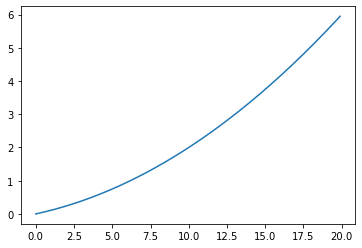

In [23]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)

plt.plot(x, y)
plt.show()

In [24]:
# x = 5일때의 미분값과 10일때의 미분값 구하기
print("x=5 일 때, 미분값 : {}".format(numerical_diff(function_1, 5)))
print("x=10 일 때, 미분값 : {}".format(numerical_diff(function_1, 10)))

x=5 일 때, 미분값 : 0.1999999999990898
x=10 일 때, 미분값 : 0.2999999999986347


In [25]:
# 접선을 그리는 코드
def tangent_line(f, x):
    d = numerical_diff(f, x)
    y = f(x) - d*x
    return lambda t: d*t + y

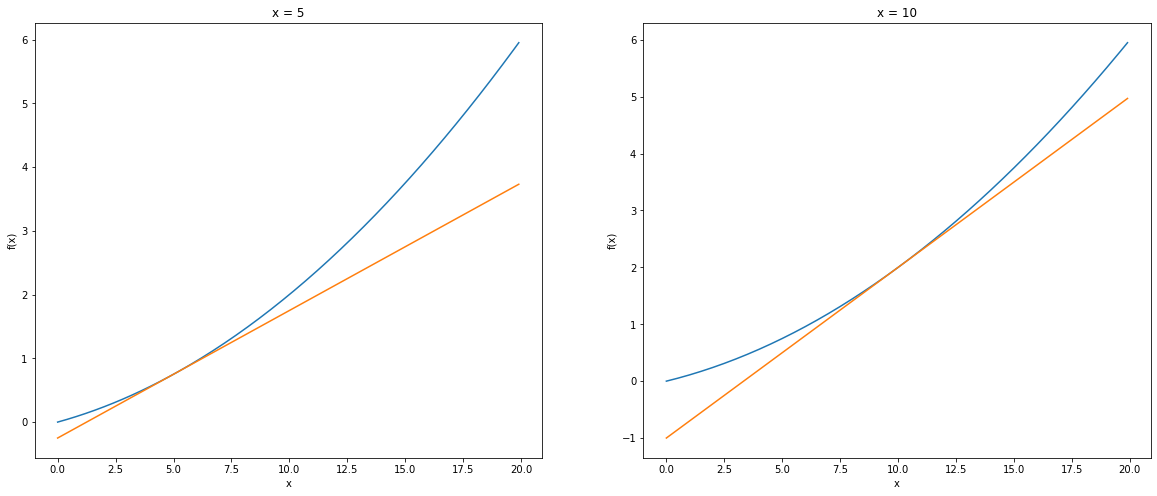

In [26]:
fig, axes = plt.subplots(1,2, figsize=(20,8))

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)

axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")
tf = tangent_line(function_1, 5)
y2 = tf(x)
axes[0].plot(x, y)
axes[0].plot(x, y2)
axes[0].set_title("x = 5")

axes[1].set_xlabel("x")
axes[1].set_ylabel("f(x)")
tf = tangent_line(function_1, 10)
y2 = tf(x)
axes[1].plot(x, y)
axes[1].plot(x, y2)
axes[1].set_title("x = 10")

plt.show()